In [1]:
# System imports
import os
import sys
from pprint import pprint as pp

# External imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter_add
import time
import pandas as pd

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

In [66]:
# Load by config file
config_file = '../configs/tripgnn.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)

In [67]:
# Load by directory (preferred)
result_base = os.path.expandvars('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/results')

In [68]:
result_name = 'agnn01'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000',
          'n_train': 100,
          'n_valid': 10,
          'n_workers': 1,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 15,
                                      'factor': 0.1,
                                      'start_epoch': 10},
                                     {'end_epoch': 20,
                                      'factor': 0.01,
                                      'start_epoch': 15}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.857039,2721.939023,108.266208,0,75.745698,0.945491,0.352315,2.509710
1,0.00100,0.794463,2724.259212,108.427731,1,69.302804,0.907053,0.388118,2.533017
2,0.00100,0.782757,2725.564609,108.569359,2,67.637492,0.811650,0.441372,3.071710
3,0.00100,0.765033,2728.302479,108.768603,3,62.987154,0.853849,0.419086,2.468363
4,0.00100,0.736097,2730.636235,108.969627,4,62.471775,0.833655,0.507418,2.610543
5,0.00100,0.711157,2732.763167,109.117591,5,72.929207,0.776304,0.557221,2.948206
6,0.00100,0.696393,2734.980366,109.263659,6,74.823660,0.838998,0.498121,3.830465
7,0.00100,0.715375,2739.722460,109.439864,7,75.842018,0.860303,0.427943,2.325757
8,0.00100,0.698324,2742.505359,109.591670,8,71.344007,0.763563,0.553331,2.661264
9,0.00100,0.693429,2745.565905,109.720133,9,68.810299,0.843328,0.441658,2.464515


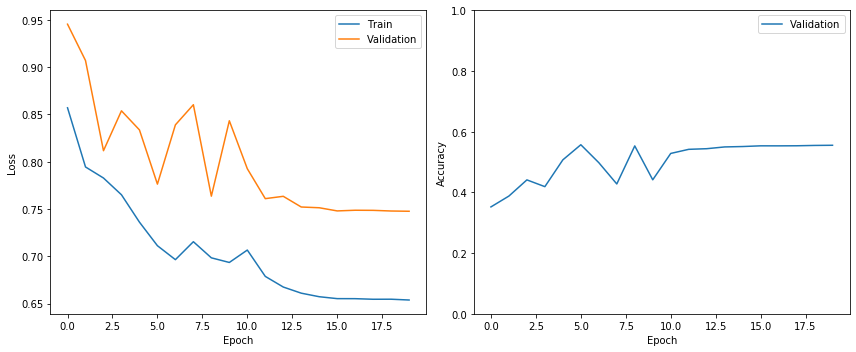

In [69]:
plot_train_history(summaries)

In [71]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
19,0.00001,0.653706,2745.694444,109.772975,19,74.183332,0.747591,0.555463,2.559959


In [70]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

In [44]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [48]:
# Load the test dataset
n_test = 3
test_loader = get_test_data_loader(config, n_test=n_test)

In [49]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

Input:  tensor([[ 0.0315,  0.3727,  0.0357],
        [ 0.0722,  0.3806,  0.0843],
        [ 0.1154,  0.3902,  0.1366],
        ...,
        [ 0.3562, -0.5672, -0.4948],
        [ 0.4967, -0.5201, -0.6904],
        [ 0.6574, -0.4659, -0.9152]])  with shape:  torch.Size([1256, 3])
Input network features:  tensor([[-0.3044, -0.7224, -0.6596,  ..., -0.5595, -0.7587, -0.8039],
        [-0.3260, -0.7246, -0.6031,  ..., -0.5356, -0.7410, -0.7933],
        [-0.3486, -0.7244, -0.5359,  ..., -0.5077, -0.7202, -0.7797],
        ...,
        [ 0.9014, -0.8742, -0.4366,  ..., -0.5954, -0.3173, -0.7670],
        [ 0.9209, -0.8621, -0.3495,  ..., -0.4387, -0.4853, -0.5225],
        [ 0.9301, -0.8391, -0.2518,  ..., -0.2479, -0.6084, -0.1512]])  with shape:  torch.Size([1256, 64])
Input concat:  tensor([[-0.3044, -0.7224, -0.6596,  ...,  0.0315,  0.3727,  0.0357],
        [-0.3260, -0.7246, -0.6031,  ...,  0.0722,  0.3806,  0.0843],
        [-0.3486, -0.7244, -0.5359,  ...,  0.1154,  0.3902,  0.1366],

Node network features:  tensor([[ 0.4472,  0.8396,  0.4145,  ...,  0.8527, -0.2266,  0.3204],
        [-0.8626, -0.5422,  0.8738,  ...,  0.9417, -0.4554, -0.8813],
        [-0.8355, -0.5522,  0.8784,  ...,  0.9320, -0.4637, -0.8793],
        ...,
        [-0.9671, -0.4950,  0.3207,  ...,  0.9007,  0.1686, -0.7175],
        [-0.4369, -0.0914,  0.1430,  ...,  0.9527,  0.0149, -0.7886],
        [ 0.8785,  0.3430, -0.2722,  ...,  0.9068,  0.5383, -0.8629]])  with shape:  torch.Size([1732, 64])
Concat node features:  tensor([[ 0.4472,  0.8396,  0.4145,  ...,  0.0330, -0.9001, -0.0116],
        [-0.8626, -0.5422,  0.8738,  ...,  0.0724, -0.8934, -0.0239],
        [-0.8355, -0.5522,  0.8784,  ...,  0.1158, -0.8865, -0.0376],
        ...,
        [-0.9671, -0.4950,  0.3207,  ...,  0.0727,  0.3256,  0.2557],
        [-0.4369, -0.0914,  0.1430,  ...,  0.1159,  0.3361,  0.4104],
        [ 0.8785,  0.3430, -0.2722,  ...,  0.2611,  0.3709,  0.9304]])  with shape:  torch.Size([1732, 67])
Iteration: 

Edge scores:  tensor([0.4350, 0.4720, 0.4571,  ..., 0.6701, 0.6699, 0.6032])  with shape:  torch.Size([5450])
Node network features:  tensor([[-0.1229,  0.3380,  0.9884,  ..., -0.7171, -0.5679, -0.8346],
        [-0.5660, -0.1593,  0.9742,  ..., -0.6738, -0.5331, -0.6401],
        [-0.9339, -0.1813,  0.9825,  ..., -0.3379, -0.5192, -0.3494],
        ...,
        [-0.3383,  0.3471,  0.9752,  ..., -0.6159, -0.6281, -0.7715],
        [ 0.5018,  0.5896,  0.7837,  ..., -0.9943, -0.0295,  0.9072],
        [ 0.2917,  0.9370, -0.5114,  ..., -0.2136, -0.5972,  0.7772]])  with shape:  torch.Size([1684, 64])
Concat node features:  tensor([[-0.1229,  0.3380,  0.9884,  ...,  0.6589, -0.9947, -0.5028],
        [-0.5660, -0.1593,  0.9742,  ...,  0.8227, -0.9552, -0.6306],
        [-0.9339, -0.1813,  0.9825,  ...,  1.0232, -0.9073, -0.7862],
        ...,
        [-0.3383,  0.3471,  0.9752,  ...,  0.6587, -0.9979, -0.4808],
        [ 0.5018,  0.5896,  0.7837,  ...,  0.0320, -0.1218, -0.1715],
        [

In [118]:
i = 2

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [119]:
e

array([[   3,    3,    3, ..., 1659, 1659, 1669],
       [   4,   44,  765, ..., 1004, 1660, 1670]])

In [120]:
e.shape

(2, 5450)

In [121]:
start, end = e

In [125]:
A = e
start, end = A
Ri = np.zeros((np.max(A)+1, A.shape[1]))
Ro = np.zeros((np.max(A)+1, A.shape[1]))
Ri[A[0,:], np.arange(A.shape[1])]=1
Ro[A[1,:], np.arange(A.shape[1])]=1

In [129]:
tic = time.time()
Riwhere = [np.nonzero(t)[0] for t in Ri]
Rowhere = [np.nonzero(t)[0] for t in Ro]
Riwhere, Rowhere
E = [np.stack(np.meshgrid(j, i),-1).reshape(-1,2) for i,j in zip(Riwhere, Rowhere)]
triplets2 = np.concatenate(E).T
toc = time.time()
print("Elapsed: ", toc-tic, " triplets2 shape: ", triplets2.shape)

Elapsed:  0.2622487545013428  triplets2 shape:  (2, 18201)


In [130]:
tic = time.time()
triplets = np.transpose(np.array([[key1,key2] for key1, val1 in enumerate(start) for key2, val2 in enumerate(end) if val1 == val2]))
toc = time.time()
print("Elapsed: ", toc-tic, " triplets shape: ", triplets.shape)

Elapsed:  9.369041442871094  triplets shape:  (2, 18201)


In [78]:
triplets.shape

(2, 26626)

In [95]:
pid = np.load('/mnt/c/Users/Daniel/Dropbox/Research/Publications/ExaTrkX/data/hitgraphs_small_000/event000001000_g000_pid.npz')

In [99]:
pid['pid'].shape

(5796,)

In [97]:
pid.items

<bound method Mapping.items of <numpy.lib.npyio.NpzFile object at 0x7fdeb9879160>>